In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

/Users/j35/anaconda/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [5]:
from PyQt4 import QtGui

In [6]:
import pyfits
import glob
from PIL import Image
from pprint import pprint

In [7]:
%gui qt

## 1. Loading the data

### a. Select input folder

In [8]:
try:
    from PySide import QtCore, QtGui
except ImportError:
    from PyQt4 import QtCore, QtGui

def gui_fname(dir=None, message=None):
    """Select a directory
    """
    if dir is None: dir ='../'
    if message is None: message = 'Select Folder ...'
    dir_name = QtGui.QFileDialog.getExistingDirectory(None, message,
                                                      dir,
                                                      QtGui.QFileDialog.ShowDirsOnly)
    return dir_name

In [9]:
%gui qt
data_folder = gui_fname()
%matplotlib inline

In [29]:
# remove hidden file .DS_Store 
ds_file = os.path.join(data_folder, ".DS_Store")
try:
    os.remove(ds_file)
except:
    pass

In [10]:
list_of_files = glob.glob(data_folder + '/*.fits')
pprint(list_of_files)

['/Users/j35/Desktop/Registration_sample/registered_data_fits/algorithm_1time/image_0000.fits',
 '/Users/j35/Desktop/Registration_sample/registered_data_fits/algorithm_1time/image_0001.fits',
 '/Users/j35/Desktop/Registration_sample/registered_data_fits/algorithm_1time/image_0002.fits',
 '/Users/j35/Desktop/Registration_sample/registered_data_fits/algorithm_1time/image_0003.fits',
 '/Users/j35/Desktop/Registration_sample/registered_data_fits/algorithm_1time/image_0004.fits',
 '/Users/j35/Desktop/Registration_sample/registered_data_fits/algorithm_1time/image_0005.fits',
 '/Users/j35/Desktop/Registration_sample/registered_data_fits/algorithm_1time/image_0006.fits',
 '/Users/j35/Desktop/Registration_sample/registered_data_fits/algorithm_1time/image_0007.fits',
 '/Users/j35/Desktop/Registration_sample/registered_data_fits/algorithm_1time/image_0008.fits',
 '/Users/j35/Desktop/Registration_sample/registered_data_fits/algorithm_1time/image_0009.fits',
 '/Users/j35/Desktop/Registration_sample

### b. Load the data

In [11]:
pbar = widgets.IntProgress()
pbar.max = len(list_of_files)
display(pbar)

list_images = []
for index, file in enumerate(list_of_files):
    o_fits = pyfits.open(file)
    o_fits_0 = o_fits[0]
    list_images.append(o_fits_0.data)
    pbar.value = index

## 2. Cropping and Saving the data

### a. Selection of Cropping region

[17, 95, 9, 227]

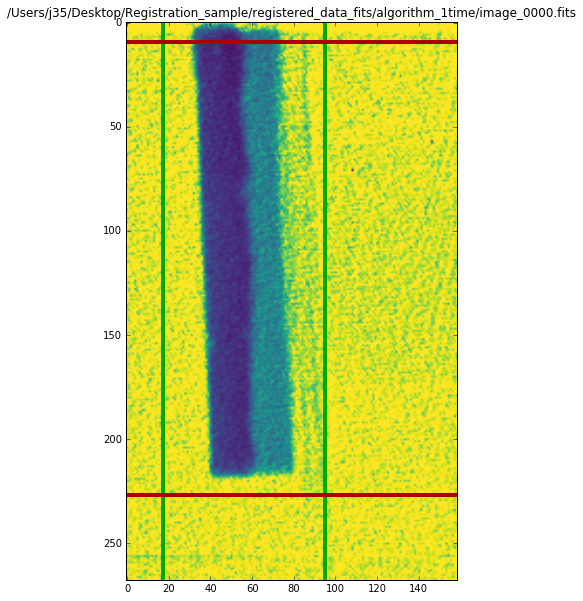

In [12]:
[height, width] = list_images[0].shape

def plot_image_with_crop_region(file_index, x_left, x_right, y_top, y_bottom):

    data = list_images[file_index]
    
    fig = plt.figure(figsize=(10, 10))
    ax_img = plt.subplot(111)

    ax_img.imshow(data, cmap='viridis')
    ax_img.set_title(list_of_files[file_index])
    ax_img.axvline(x_left, color='#00aa00', linewidth=4)
    ax_img.axvline(x_right, color='#00aa00', linewidth=4)
    ax_img.axhline(y_bottom, color='#aa0000', linewidth=4)
    ax_img.axhline(y_top, color='#aa0000', linewidth=4)   
    
    return [x_left, x_right, y_top, y_bottom]

number_of_files = len(list_of_files)
crop = interact(plot_image_with_crop_region, 
        file_index =widgets.IntSlider(min=0, max=number_of_files-1, step=1, value=0, description='Image index'),
        x_left = widgets.IntSlider(min=0, max=width-1, step=1, value=0),
        x_right = widgets.IntSlider(min=0, max=width-1, step=1, value=width-1),
        y_top = widgets.IntSlider(min=0, max=height-1, step=1, value=0), 
        y_bottom = widgets.IntSlider(min=0, max=height-1, step=1, value=height-1))

### b. Preview of Cropping on images

In [13]:
[x_left, x_right, y_top, y_bottom] = crop.widget.result
print('Region Selected:')
print('  left : %d' %x_left)
print('  right: %d' %x_right)
print('    top: %d' %y_top)
print(' bottom: %d' %y_bottom)

Region Selected:
  left : 17
  right: 95
    top: 9
 bottom: 227


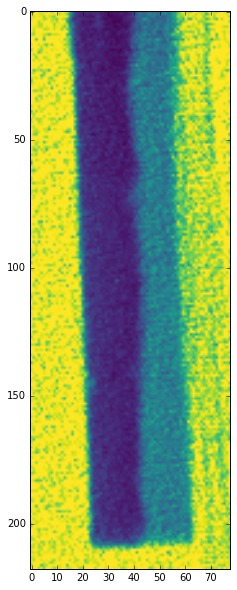

In [14]:
def test_plot_image_cropped(file_index):

    image_file = os.path.join(data_folder, list_of_files[file_index])
    data = list_images[file_index]
    data_cropped = data[y_top: y_bottom, x_left: x_right]
    
    fig = plt.figure(figsize=(10, 10))
    ax_img = plt.subplot(111)

    ax_img.imshow(data_cropped, cmap='viridis')

crop_preview = interact(test_plot_image_cropped, 
        file_index =widgets.IntSlider(min=0, max=number_of_files-1, step=1, value=0, description='Image index'))


### c. Crop all images and save images into fits files

In [15]:
%gui qt
output_folder = gui_fname(dir = data_folder)
%matplotlib inline

In [16]:
pbar = widgets.IntProgress()
pbar.max = number_of_files
display(pbar)

for index, file_name in enumerate(list_of_files):
        _data = list_images[index]
        data_cropped = _data[y_top: y_bottom, x_left: x_right]

        new_image = Image.fromarray(np.float32(data_cropped))
        file_name = 'image_%.4d.fits' %index
        output_file_name = os.path.join(output_folder, file_name)
#        print(output_file_name)
        hdu = pyfits.PrimaryHDU(new_image)
        hdu.writeto(output_file_name)
        pbar.value = index+1